In [172]:
import pandas as pd
file_name = 'data/qa_queries_V28.parquet'
#load data
df = pd.read_parquet(file_name)

In [173]:
# sort by lat, time
df = df.sort_values(by=['lat', 'time'])

In [174]:
df.columns

Index(['point', 'time', 'lat', 'lon', 'ndvi.landsat', 'qa.landsat',
       'ndvi.modis', 'qa.modis', 'ndvi.sentinel2', 'qa.sentinel2',
       'ndvi.streambatch', 'source.streambatch'],
      dtype='object')

In [175]:
# slice off all rows where qa.sentinel2 == 1
s2 = df[df['qa.sentinel2'] == 1].copy()

# remove all columns except time, lat, ndvi.sentinel2
s2 = s2[['time', 'lat', 'ndvi.sentinel2']]
# rename ndvi.sentinel2 to ndvi
s2 = s2.rename(columns={'ndvi.sentinel2': 'ndvi'})
# remove any row where ndvi is the same as the previous row
s2 = s2[s2['ndvi'] != s2['ndvi'].shift(1)]

# slice off all rows where qa.landsat8 == 1
l8 = df[df['qa.landsat'] == 1].copy()
# remove all columns except time, lat, ndvi.landsat
l8 = l8[['time', 'lat', 'ndvi.landsat']]
# rename ndvi.landsat to ndvi
l8 = l8.rename(columns={'ndvi.landsat': 'ndvi'})
# remove any row where ndvi is the same as the previous row
l8 = l8[l8['ndvi'] != l8['ndvi'].shift(1)]
# concat s2 and l8
m = pd.concat([s2, l8])
# sort by lat, time
m = m.sort_values(by=['lat', 'time'])
# reset index
m = m.reset_index(drop=True)
m.head()


,time,lat,ndvi
0,2013-04-22,-34.065146,0.451291
1,2013-07-20,-34.065146,0.718348
2,2013-08-05,-34.065146,0.688542
3,2013-08-12,-34.065146,0.763199
4,2013-09-06,-34.065146,0.680351


In [207]:
# save m to disk
m.to_parquet('data/s2l8.parquet')
# load it back
# m = pd.read_parquet('data/s2l8.parquet')

In [185]:
# get all the unique lats
lats = df['lat'].unique()

# save lats to file
lats.tofile('data/lats.bin')
# load lats from file
lats = np.fromfile('data/lats.bin', dtype=np.float64)

In [177]:
m.columns

Index(['time', 'lat', 'ndvi'], dtype='object')

In [178]:
m.dtypes

time    datetime64[ns]
lat            float64
ndvi           float64
dtype: object

In [198]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter

def f(m):

    # Step 2: Create a new DataFrame 'm1' with all dates from the minimum to maximum date in 'm'
    min_date = m["time"].min()
    max_date = m["time"].max()
    date_range = pd.date_range(min_date, max_date, freq='D')  # Create a date range with daily frequency
    m1 = pd.DataFrame({"time": date_range})

    # Step 3: Merge the original 'ndvi' values into the new DataFrame 'm1' using outer join
    m1 = pd.merge(m1, m, on="time", how="left")

    # Step 4: Interpolate missing values in the 'ndvi' column
    m1["ndvi"] = m1["ndvi"].interpolate()

    # Step 5: Use savgol_filter to smooth the "ndvi" column in 'm1'
    window_length = 20  # Adjust the window length as needed
    polyorder = 2  # Adjust the polynomial order as needed

    # Fill missing values with NaN, so the filter doesn't treat them as zeros
    m1["ndvi"] = m1["ndvi"].replace(0, np.nan)

    # Apply the savgol_filter to smooth the "ndvi" column
    m1["ndvi_smoothed"] = savgol_filter(m1["ndvi"], window_length, polyorder)


    return m1


In [199]:
# m1 = m[m['lat'] == lats[0]]
# # m1 = m1.drop(columns=['lat'])
# f(m1).tail(40)


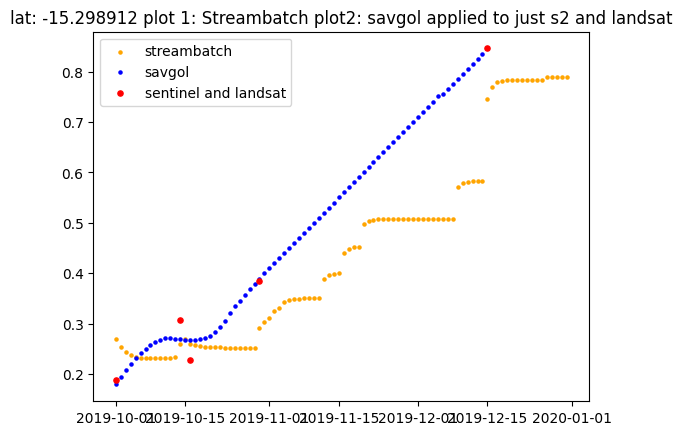

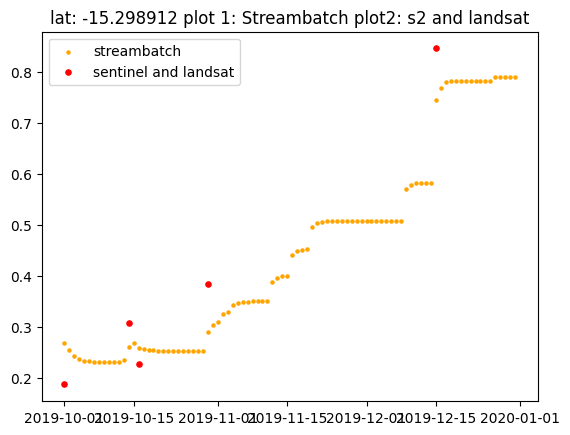

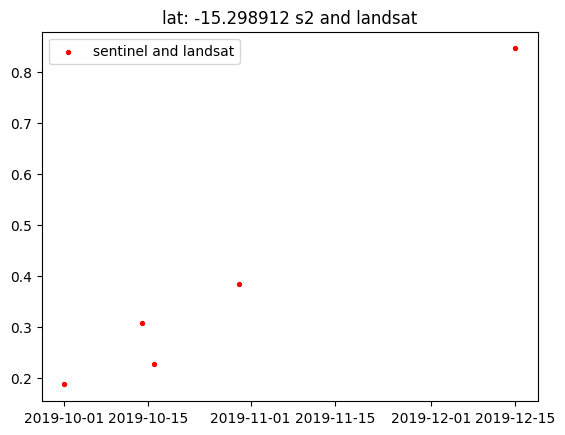

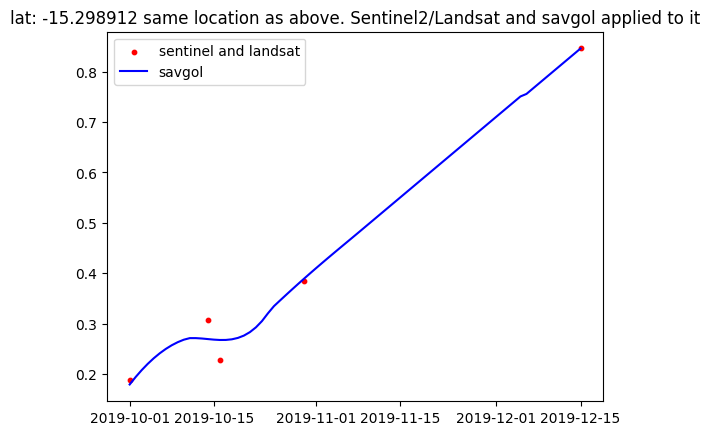

lat: -15.298912


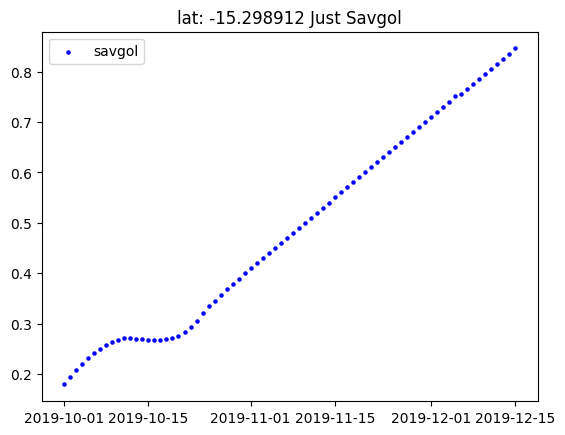

In [208]:
import matplotlib.pyplot as plt
start_date = '2019-10-01'
end_date = '2019-12-31'
for l in lats[3:4]:
    this = df[df['lat'] == l]
    m1 = m[m['lat'] == l]
    this = this[(this['time'] >= start_date) & (this['time'] <= end_date)]
    m1 = m1[(m1['time'] >= start_date) & (m1['time'] <= end_date)]

    
    fitted = f(m1)


    
    plt.scatter(this['time'], this['ndvi.streambatch'], label='streambatch',s=5,color='orange')
    plt.scatter(fitted['time'], fitted['ndvi_smoothed'], label='savgol',s=5,color='blue')
    plt.scatter(m1['time'], m1['ndvi'], label='sentinel and landsat',s=14, color="red")
    plt.title(f"lat: {l} plot 1: Streambatch plot2: savgol applied to just s2 and landsat")
    plt.legend()
    plt.show()

    plt.scatter(this['time'], this['ndvi.streambatch'], label='streambatch',s=5,color='orange')
    plt.scatter(m1['time'], m1['ndvi'], label='sentinel and landsat',s=14, color="red")
    plt.title(f"lat: {l} plot 1: Streambatch plot2: s2 and landsat")
    plt.legend()
    plt.show()

    plt.scatter(m1['time'], m1['ndvi'], label='sentinel and landsat',s=8, color="red")
    plt.title(f"lat: {l} s2 and landsat")
    plt.legend()
    plt.show()

    
    
    plt.scatter(m1['time'], m1['ndvi'], label='sentinel and landsat',s=10, color="red")
    plt.plot(fitted['time'], fitted['ndvi_smoothed'], label='savgol', color='blue')
    plt.title(f"lat: {l} same location as above. Sentinel2/Landsat and savgol applied to it")
    plt.legend()

    plt.show()
    print(f"lat: {l}")
    plt.scatter(fitted['time'], fitted['ndvi_smoothed'], label='savgol',s=5, color='blue')
    plt.title(f"lat: {l} Just Savgol")
    plt.legend()

    plt.show()
    v = fitted['ndvi_smoothed']
    # save v to a file called temp.csv
    v.to_csv(f'data/{l}.csv', index=False)


    

